In [1]:
import os
os.chdir('/content/drive/MyDrive/FuseAI_Training')

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('ISEAR.csv', names=['SN','Label','Text'], index_col = 'SN')
df.head()

,Label,Text
SN,,
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [4]:
df.describe()

,Label,Text
count,7446,7446
unique,7,7379
top,joy,When my grandfather died.
freq,1082,8


In [5]:
list(df['Label'].unique())

['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt']

In [6]:
total = df.isnull().sum()
total

Label    0
Text     0
dtype: int64

Distribution of sentiments in the data

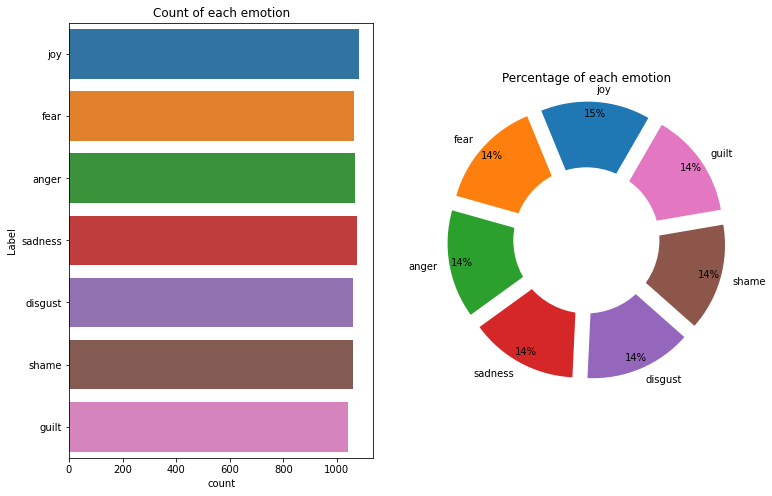

In [7]:
col = 'Label'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [8]:
df['char_length'] = df['Text'].apply(lambda x : len(x))
df['token_length'] = df['Text'].apply(lambda x : len(x.split(" ")))

Distribution of character length and token length overall


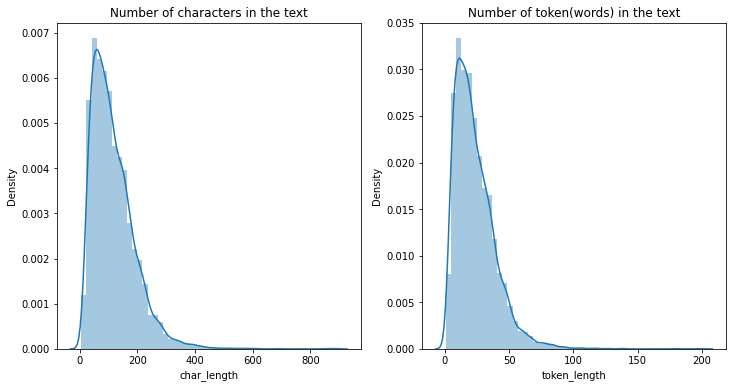

In [9]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the text')
ax2.set_title('Number of token(words) in the text')
plt.show()


Distribution of character length sentiment-wise

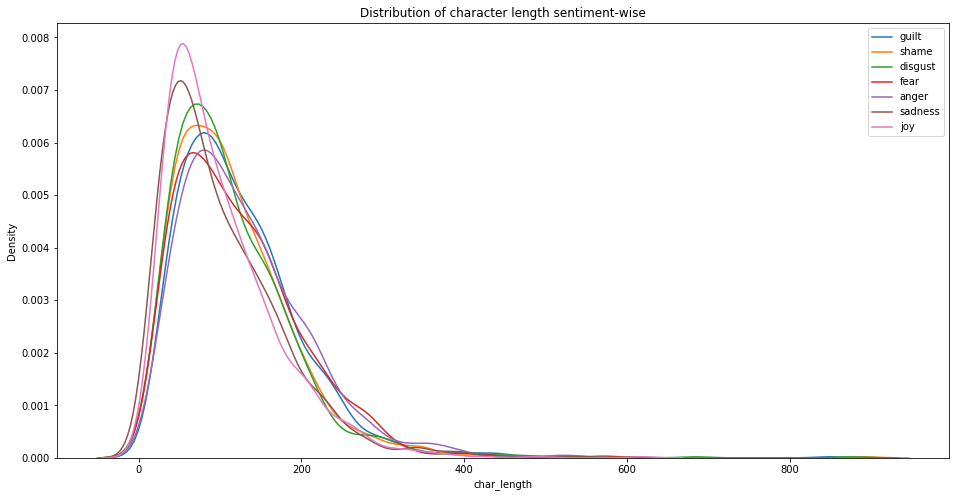

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
for sentiment in df['Label'].value_counts().sort_values()[-7:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['Label']==sentiment]['char_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise")
plt.show()

Distribution of token length sentiment-wise

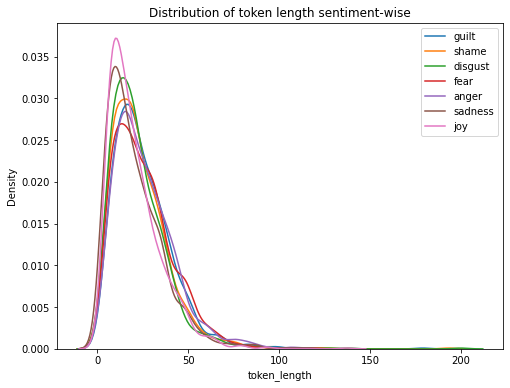

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
for sentiment in df['Label'].value_counts().sort_values()[-7:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['Label']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise")
plt.show()

Let's look at the most common character and token length


In [12]:
avg_df = df.groupby('Label').agg({'char_length':'mean', 'token_length':'mean'})

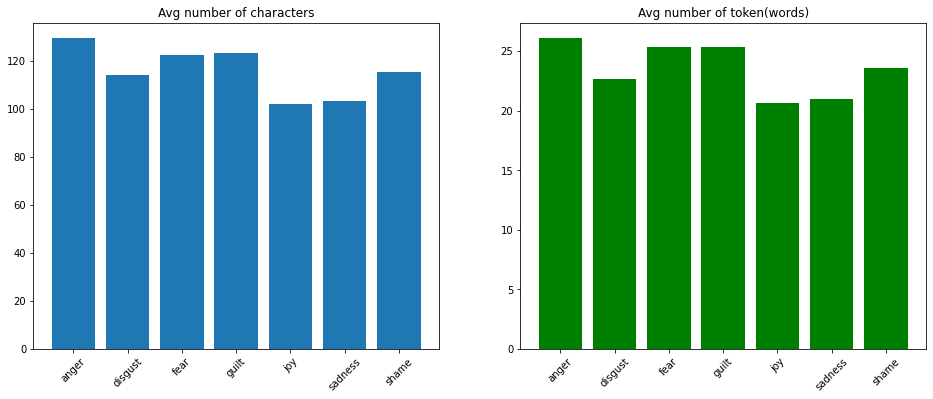

In [13]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

## Text-preprocessing

In [14]:
!pip install contractions

     |████████████████████████████████| 327kB 27.8MB/s 
     |████████████████████████████████| 286kB 48.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85398 sha256=c0cdff8a095662b7adc2e547ae60b13fc04137d4232c9adde873861dd717e483
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [16]:

def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    # Denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    # Text-normalization
   
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    return df

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [18]:
print("Before Text Preprocessing")
display(df.head()[['Text']])
processed_df = text_preprocessing_platform(df, 'Text', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['Text']])

Before Text Preprocessing


,Text
SN,
0,On days when I feel close to my partner and ot...
1,Every time I imagine that someone I love or I ...
2,When I had been obviously unjustly treated and...
3,When I think about the short time that we live...
4,At a gathering I found myself involuntarily si...


After Text Preprocessing


,Text
SN,
0,days feel close partner friends feel peace als...
1,every time imagine someone love could contact ...
2,obviously unjustly treat possibility elucidate
3,think short time live relate periods life thin...
4,gather find involuntarily sit next two people ...


## Uni-gram Analysis

In [19]:
#find out the most frequent words in the corpus

def print_word_cloud(df, sentiment):

    print("Word cloud of most frequent words for the sentiment : {}".format(sentiment))

    temp_df = df[df['Label']==sentiment]
    print("Number of Rows : ", len(temp_df))

    corpus = ''
    for text in temp_df.Text:
        text = str(text)
        corpus += text
        
    total = 0
    count = defaultdict(lambda: 0)
    for word in corpus.split(" "):
        total += 1
        count[word] += 1
        
    top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
    top20words = [i[0] for i in top20pairs]
    top20freq = [i[1] for i in top20pairs]
    
    xs = np.arange(len(top20words))
    width = 0.5

    fig = plt.figure(figsize=(10,6))                                                               
    ax = fig.gca()
    ax.bar(xs, top20freq, width, align='center')

    ax.set_xticks(xs)
    ax.set_xticklabels(top20words)
    plt.xticks(rotation=45)
    
    
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_font_size=50, max_words=50,stopwords=stopwords, background_color="white").generate(corpus)
    plt.figure(figsize = (12, 12), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Word cloud of most frequent words for the sentiment : sadness
Number of Rows :  1074


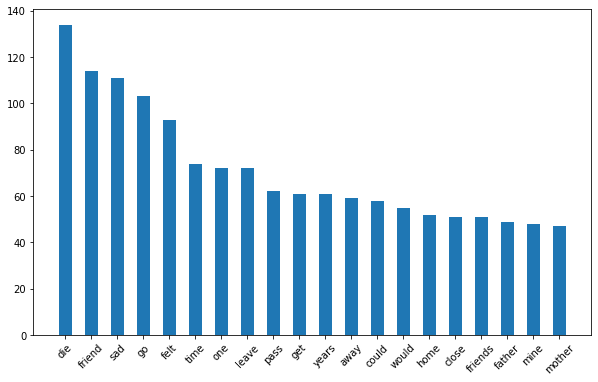

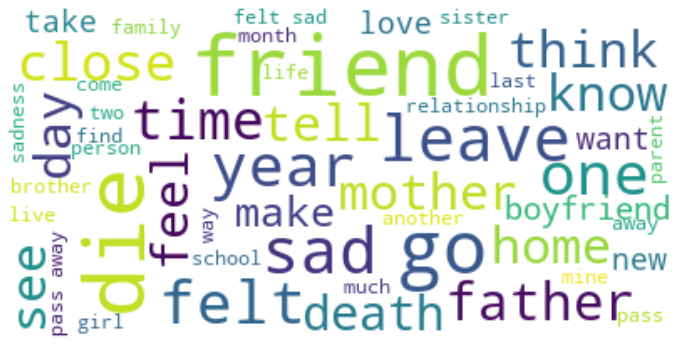

In [20]:
print_word_cloud(df, 'sadness')

Word cloud of most frequent words for the sentiment : joy
Number of Rows :  1082


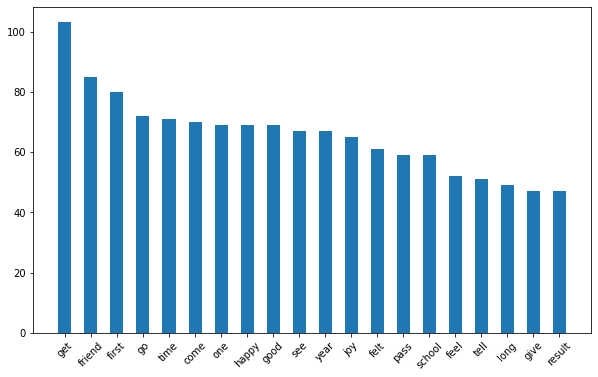

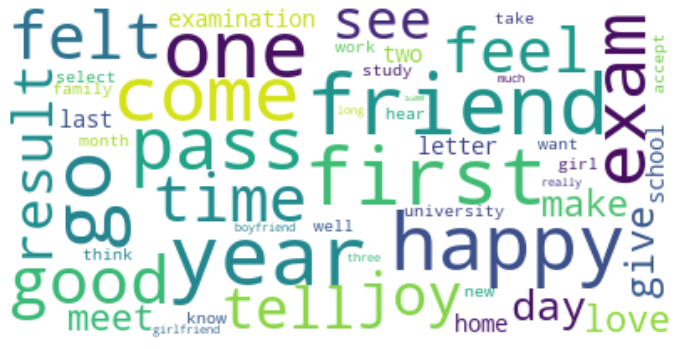

In [21]:
 print_word_cloud(df, 'joy')

Word cloud of most frequent words for the sentiment : fear
Number of Rows :  1063


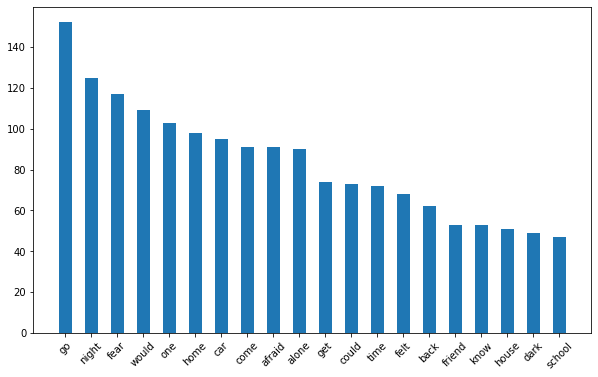

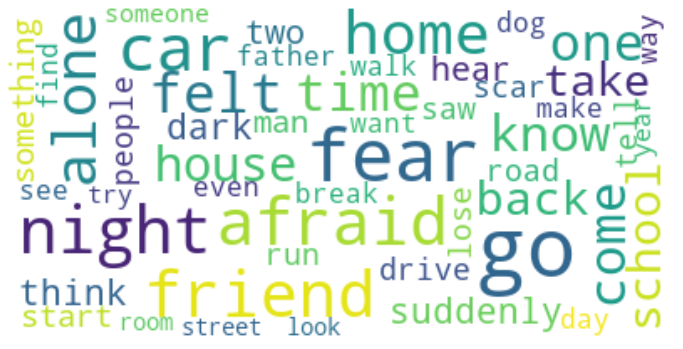

In [22]:
 print_word_cloud(df, 'fear')

Word cloud of most frequent words for the sentiment : anger
Number of Rows :  1069


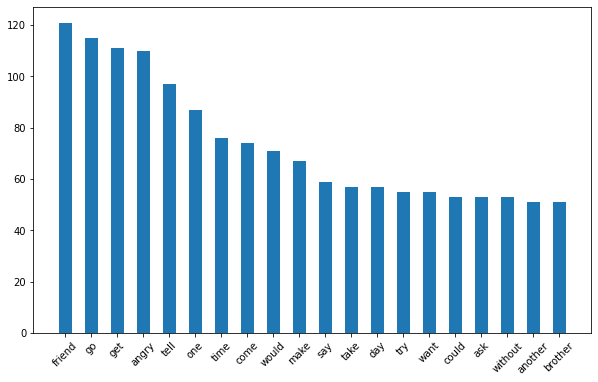

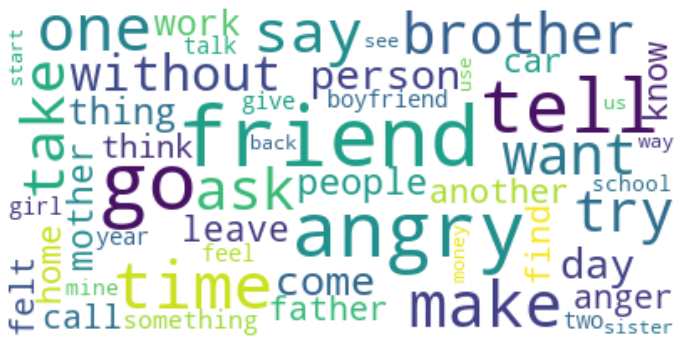

In [23]:
 print_word_cloud(df, 'anger')

Word cloud of most frequent words for the sentiment : disgust
Number of Rows :  1059


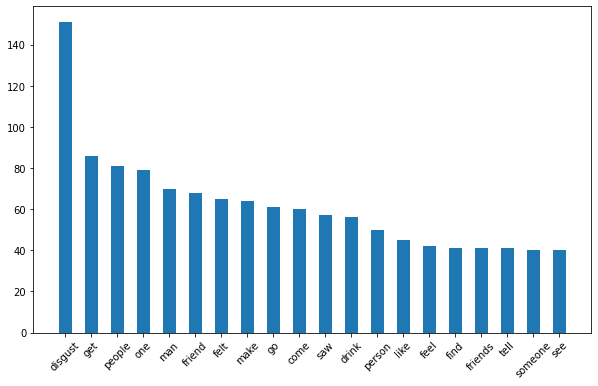

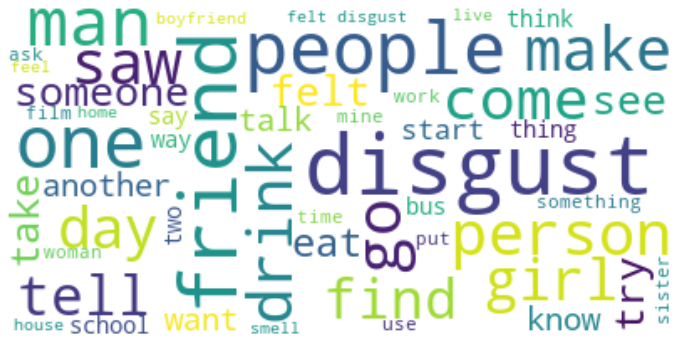

In [24]:
 print_word_cloud(df, 'disgust')

Word cloud of most frequent words for the sentiment : shame
Number of Rows :  1059


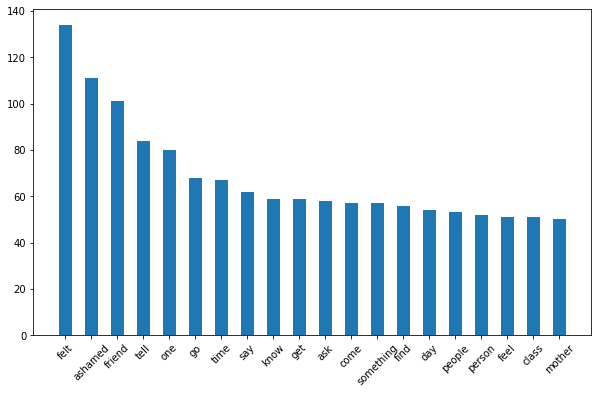

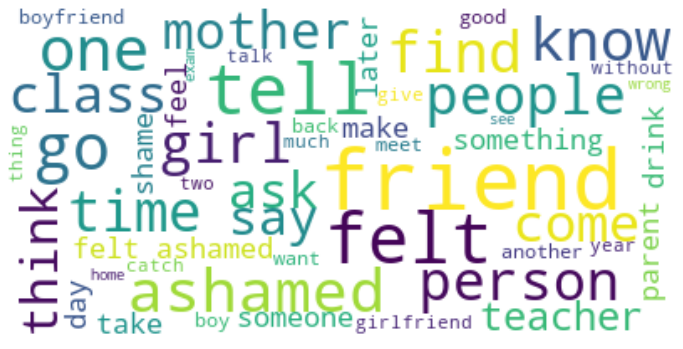

In [25]:
 print_word_cloud(df, 'shame')

Word cloud of most frequent words for the sentiment : guilt
Number of Rows :  1040


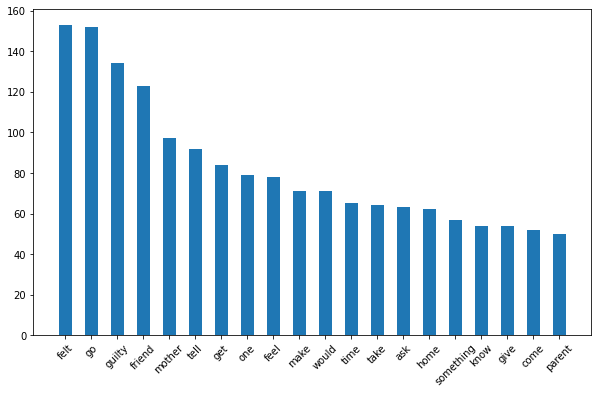

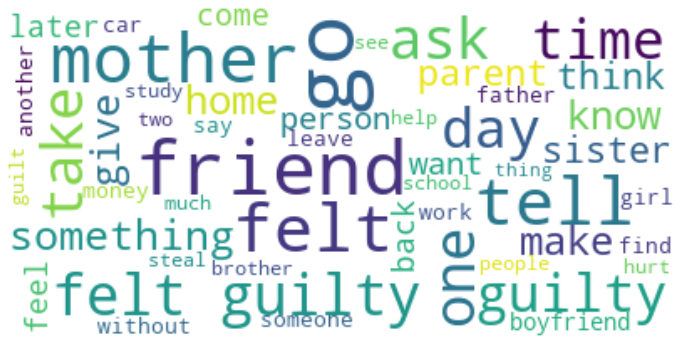

In [26]:
 print_word_cloud(df, 'guilt')